# Loading Radar Data

In [1]:
# Import Necessary Libraries
import os
import numpy as np
from datetime import datetime
import pysteps
# Import utility functions from the repository (custom functions for data loading and other functionalities
import utility   
import matplotlib.pyplot as plt
from pprint import pprint
from pysteps import io, nowcasts, rcparams
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.postprocessing.ensemblestats import excprob
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field


root_path = os.getcwd()
# Define the data directory for the repository data
data_path = os.path.join(root_path, "Data")
# Define metadata files
metadata_X = utility.get_matadata(os.path.join(data_path, "radarmappatipo.tif"), type="X")
folders = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
events = [event for event in os.listdir(os.path.join(data_path,
                                                     'UNICA_SG')) if os.path.isdir(os.path.join(data_path,
                                                                                                'UNICA_SG', event))]
# Define parameters for X-band radar data
data_source_X = 'UNICA_SG'
event_subdir ='20230520_2235' # this is the event folder, we can change for different events from the events variable
f_ext_X = "png"
# for LK, VET and proesman we need 4 files (3 previous files from the central scan) and for DARTS we need 10 files (9 previous files)
num_prev_files = 3  
num_next_files = 6 # In our study we are doing nowcast for next 30 mins (6 scans) 
timestep = 5
# Choose the date for particular subset
eventdates = [eventdate for eventdate in os.listdir(os.path.join(data_path,
                                                                 'UNICA_SG',
                                                                 event_subdir)) if os.path.isfile(os.path.join(data_path,
                                                                                                               'UNICA_SG', 
                                                                                                               event_subdir,
                                                                                                               eventdate))]
# extract the date in datetime format from the filename
# This is the central scan, we have to previous load files for optical flow and next files to compare the nowacasting results with observation
date = datetime.strptime('20230520_1830.png', "%Y%m%d_%H%M.png") 
# Load X-band radar data
R_dn, metadata_dn = utility.import_files_by_date(date, 
                                           data_path, 
                                           data_source_X,
                                           event_subdir, 
                                           f_ext_X, 
                                           metadata_X,
                                           num_prev_files,
                                           0,
                                           timestep)


# Noise removal using Watershed technique
R_dn_clean = np.empty_like(R_dn)
for t in range(R_dn.shape[0]):
    R_dn_clean[t, :, :] = utility.noise_remove(R_dn[t, :, :], type="Watershed")

# Convert Digital Number to Reflectivity (dBZ)
R_dbz,metadata_dbz = utility.dn_to_dbz(R_dn_clean,metadata_dn)
# Convert to rain rate
R_R, metadata_R = conversion.to_rainrate(R_dbz, metadata_dbz)
# Log-transform the data to unit of dBR, set the threshold to 0.1 mm/h,
# set the fill value to -15 dBR
R_dbr, metadata_dbr = transformation.dB_transform(R_R, metadata_R, threshold=0.1, zerovalue=-15.0)

# Set missing values with the fill value
R_dbr[~np.isfinite(R_dbr)] = -15.0

# Nicely print the metadata
pprint(metadata_dbr)

Pysteps configuration file found at: /opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/pystepsrc



/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


{'accutime': 5,
 'cartesian_unit': 'm',
 'institution': 'UNICA',
 'product': 'png',
 'projection': '+proj=tmerc +lat_0=0 +lon_0=9 +k=0.9996 +x_0=1500000 +y_0=0 '
               '+ellps=intl '
               '+towgs84=-104.1,-49.1,-9.9,0.971,-2.917,0.714,-11.68 +units=m '
               '+no_defs +type=crs',
 'threshold': np.float64(-10.0),
 'timestamps': array([datetime.datetime(2023, 5, 20, 18, 15),
       datetime.datetime(2023, 5, 20, 18, 20),
       datetime.datetime(2023, 5, 20, 18, 25),
       datetime.datetime(2023, 5, 20, 18, 30)], dtype=object),
 'transform': 'dB',
 'unit': 'mm/h',
 'x1': 1478699.0,
 'x2': 1540139.0,
 'xpixelsize': 60.0,
 'y1': 4311475.0,
 'y2': 4372915.0,
 'yorigin': 'upper',
 'ypixelsize': 60.0,
 'zerovalue': -15.0,
 'zr_a': 53.89,
 'zr_b': 0.86}


# Load observed data to compare with nowcast results

In [2]:
R_O, metadata_O = utility.import_files_by_date(date, 
                                               data_path, 
                                               data_source_X,
                                               event_subdir, 
                                               f_ext_X, 
                                               metadata_X,
                                               None,
                                               num_next_files,
                                               timestep)
# Noise removal using Watershed technique
R_O_clean = np.empty_like(R_O)
for t in range(R_O.shape[0]):
    R_O_clean[t, :, :] = utility.noise_remove(R_O[t, :, :], type="Watershed")

# Convert Digital Number to Reflectivity (dBZ)
R_O_dbz,metadata_O_dbz = utility.dn_to_dbz(R_O_clean,metadata_O)
# Convert to rain rate
R_O_R, metadata_O_R = conversion.to_rainrate(R_O_dbz, metadata_O_dbz)

In [3]:
R_O.shape

(6, 1024, 1024)

# Estimate the motion field 

Computing the motion field with the Lucas-Kanade method.
--- 10 outliers detected ---
--- LK found 342 sparse vectors ---
--- 123 samples left after declustering ---
--- total time: 5.49 seconds ---


/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(


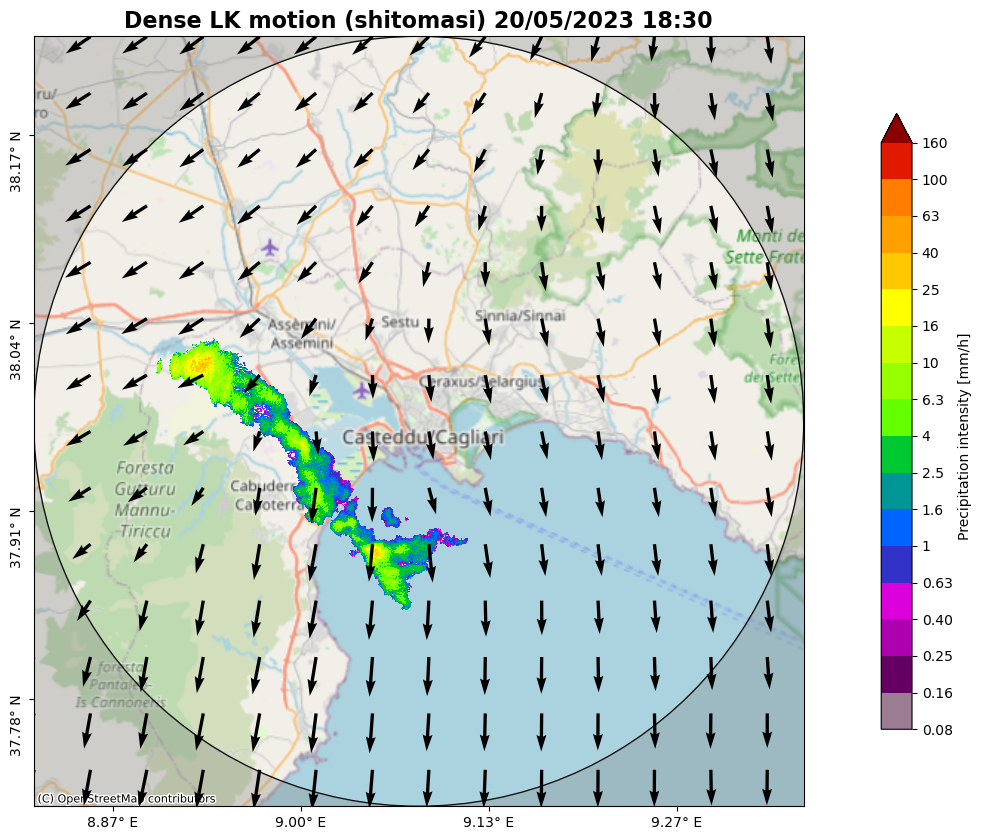

In [4]:
# motion field using lucas kanade optical flow (dense method) with shitomasi tracking methods
from pysteps.visualization import quiver

V1 = dense_lucaskanade(R_dbr,fd_method="shitomasi",verbose=True)
fig, ax = plt.subplots(figsize=(20, 10))

plot_precip_field(
            R_R[-1, :, :],
            ptype="intensity",
            geodata=metadata_R,
            units="mm/h",
            ax=ax,
            colorscale="pysteps")
ax.set_title(f"Dense LK motion (shitomasi) {metadata_R['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}", fontsize=16,weight="bold")
quiver(V1, geodata=metadata_R, step=75,ax=ax)     
utility.plot_modification(ax,metadata_R)
plt.savefig("dense_lk_motion.png", dpi=300, bbox_inches="tight")
plt.show()

# Deterministic nowcast with SPROG

In [5]:
# Set nowcast parameters
n_ens_members = 20
n_leadtimes = num_next_files
seed = 24
# The S-PROG nowcast
sprog = nowcasts.get_method("sprog")
R_f_sp = sprog(
    R_dbr[-3:, :, :],
    V1,
    n_leadtimes,
    n_cascade_levels=6,
    R_thr=-10.0
)
# Back-transform to rain rate
R_f_sp = transformation.dB_transform(R_f_sp, threshold=-10.0, inverse=True)[0]

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/decorators.py:307: FutureWarning: Argument 'R_thr' has been renamed to 'precip_thr'. This will raise a TypeError in pysteps 1.8.0.
  warnings.warn(


Computing S-PROG nowcast
------------------------

Inputs
------
input dimensions: 1024x1024

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     6
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.998754      | 0.990169      |
-----------------------------------------
| 2     | 0.988674      | 0.958563      |
-----------------------------------------
| 3     | 0.895705      | 0.682491      |
--------------------

# Deterministic nowcast with semilagrangian extrapolation

In [6]:
# Extrapolate the last radar observation
extrapolate = nowcasts.get_method("extrapolation")
R_f_sl = extrapolate(R_dbr[-1, :, :], 
                     V1, 
                     n_leadtimes,extrap_method="semilagrangian")

# Back-transform to rain rate
R_f_sl = transformation.dB_transform(R_f_sl, threshold=-10.0, inverse=True)[0]

# Deterministic nowcast with ANVIL

In [7]:
anvil = nowcasts.get_method("anvil")
R_f_A =  anvil(R_R[-4:,:,:], 
               V1, 
               n_leadtimes, 
               ar_window_radius=25, 
               ar_order=2)

Computing ANVIL nowcast
-----------------------

Inputs
------
input dimensions: 1024x1024

Methods
-------
extrapolation:   semilagrangian
FFT:             numpy

Parameters
----------
number of time steps:        6
parallel threads:            1
number of cascade levels:    6
order of the ARI(p,1) model: 2
ARI(p,1) window radius:      25
R(VIL) window radius:        3
Starting nowcast computation.
Computing nowcast for time step 1... done.
done.ting nowcast for time step 2... 
done.ting nowcast for time step 3... 
done.ting nowcast for time step 4... 
done.ting nowcast for time step 5... 
done.ting nowcast for time step 6... 


# Deterministic nowcast with Eulerian persistence

In [8]:
# Extrapolate the last radar observation
extrapolate = nowcasts.get_method("extrapolation")
R_f_el = extrapolate(R_dbr[-1, :, :], 
                     V1, 
                     n_leadtimes,
                     extrap_method="eulerian")

# Back-transform to rain rate
R_f_el = transformation.dB_transform(R_f_el, threshold=-10.0, inverse=True)[0]

# Function to plot nowcasting frames

In [9]:
# Time indices corresponding to t-15 min, t-10 min, t-5 min, t min
input_indices = [0,1,2,3]
# Time indices corresponding to t+5 min, t+10 min, t+15 min and t+30 min
output_indices = [0,1,2,5]
# Subplot radar data with improved aesthetics
def plot_radar_data(data, metadata, time_indices, text):
    fig, axes = plt.subplots(1, len(time_indices), figsize=(32, 8))
    for i, idx in enumerate(time_indices):
        ax = axes[i]
        plot_precip_field(
            data[idx, :, :],
            ptype="intensity",
            geodata=metadata,
            units="mm/h",
            ax=ax,
            colorscale="pysteps"
        )
        ax.set_title(f"{text} {metadata['timestamps'][idx].strftime('%d/%m/%Y %H:%M')}", fontsize=12,weight="bold")
        utility.plot_modification(ax, metadata)
    plt.tight_layout()
    plt.savefig(f"{text.lower().strip()}_radar_data.png", dpi=300, bbox_inches="tight")
    plt.show()

# Plot each nowcasts

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(


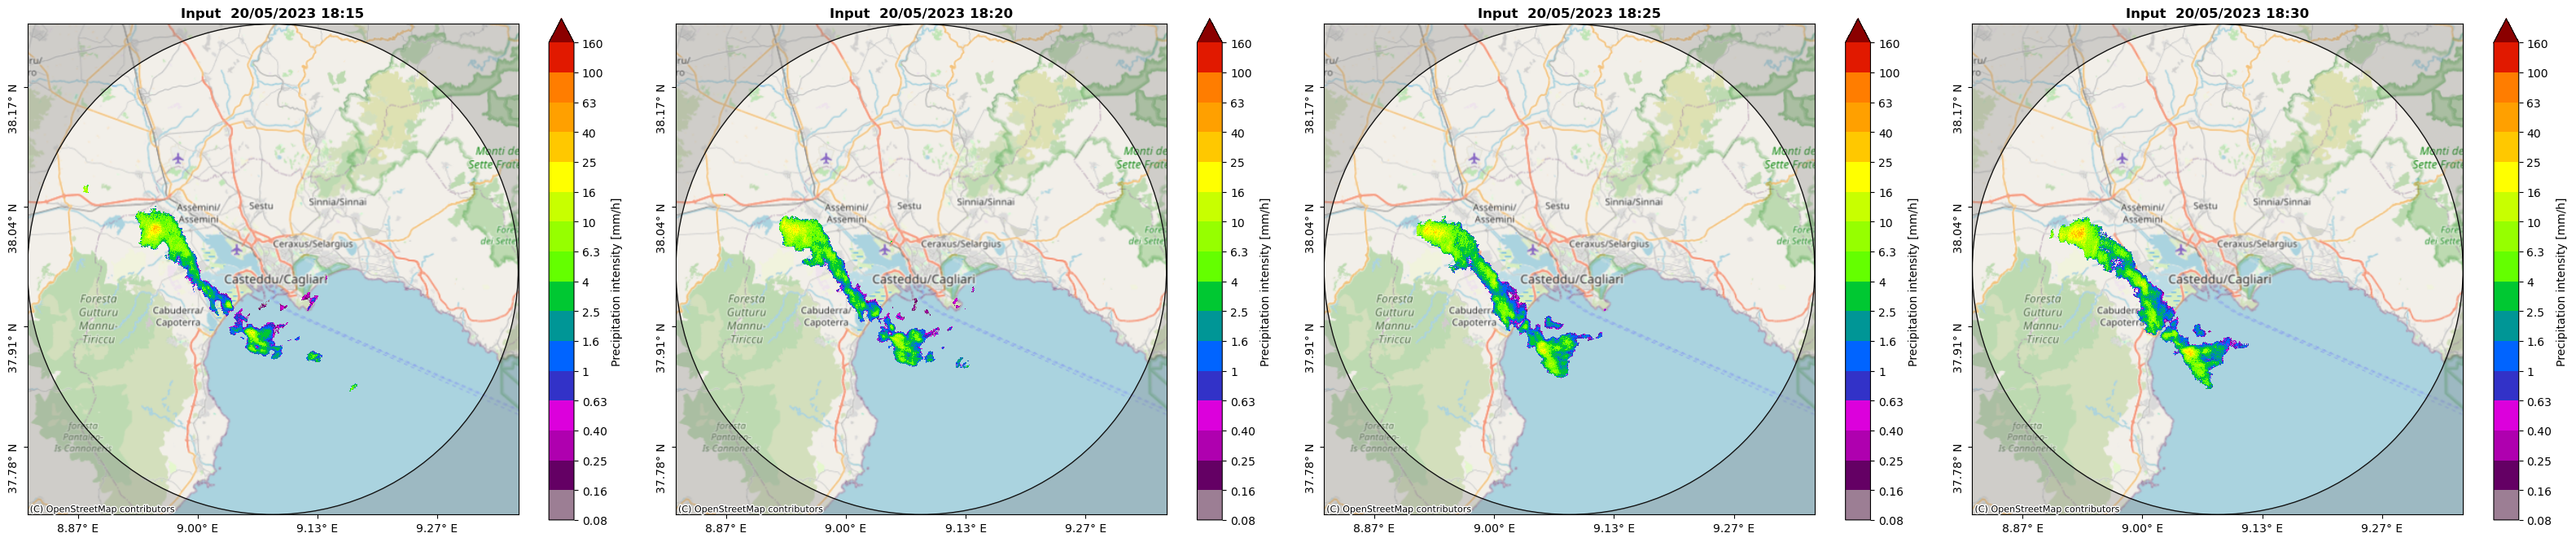

In [10]:
plot_radar_data(R_R, metadata_R, input_indices, "Input ")

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
 

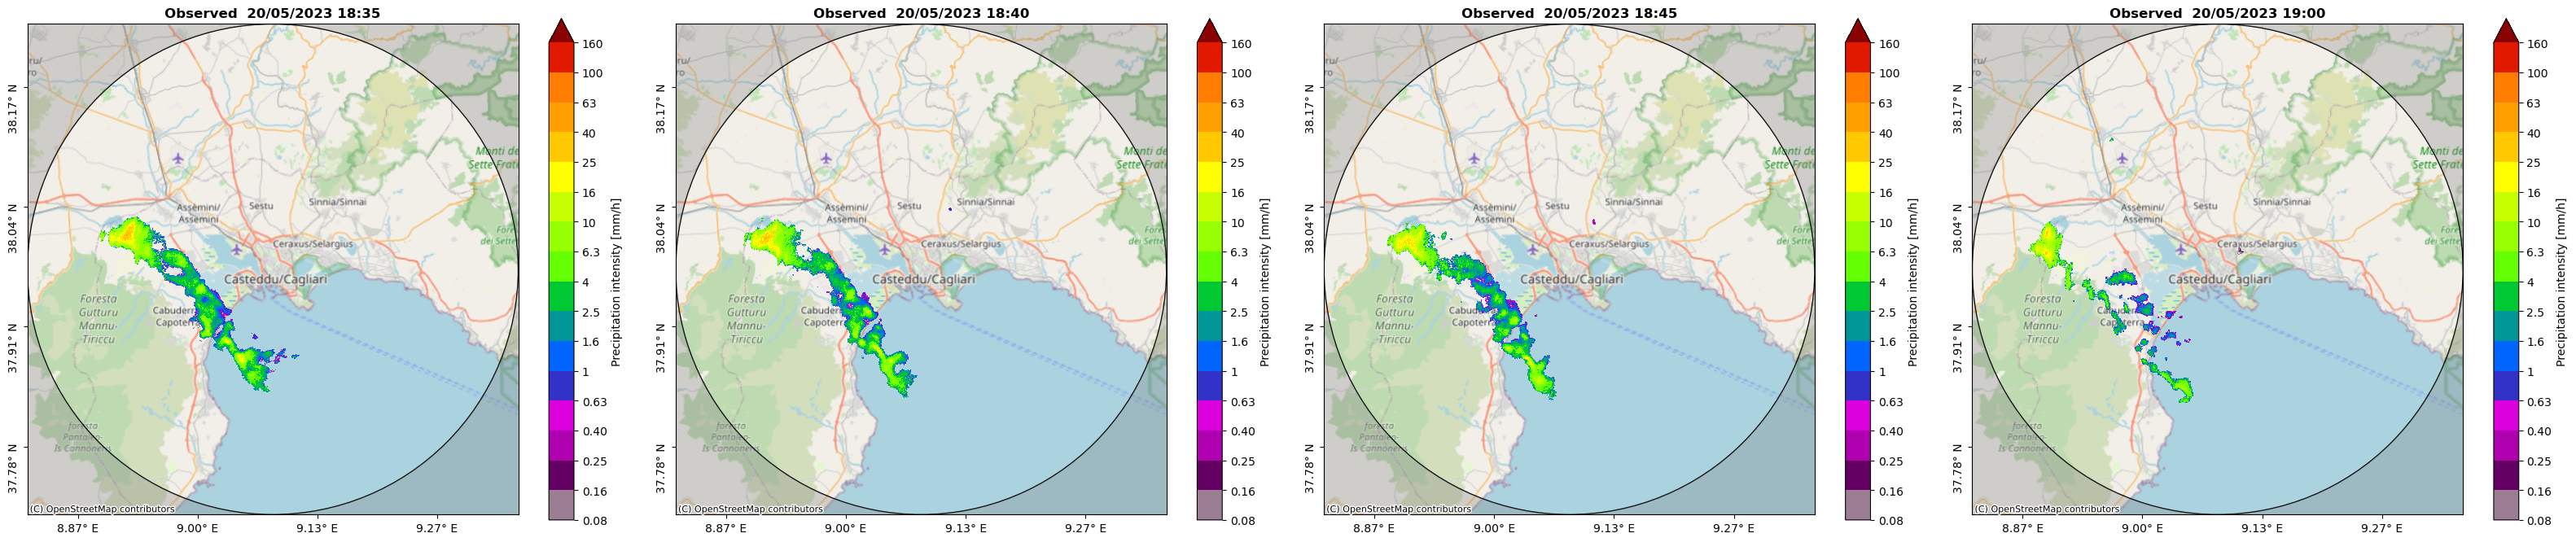

In [11]:
plot_radar_data(R_O_R, metadata_O_R, output_indices, "Observed ")

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
 

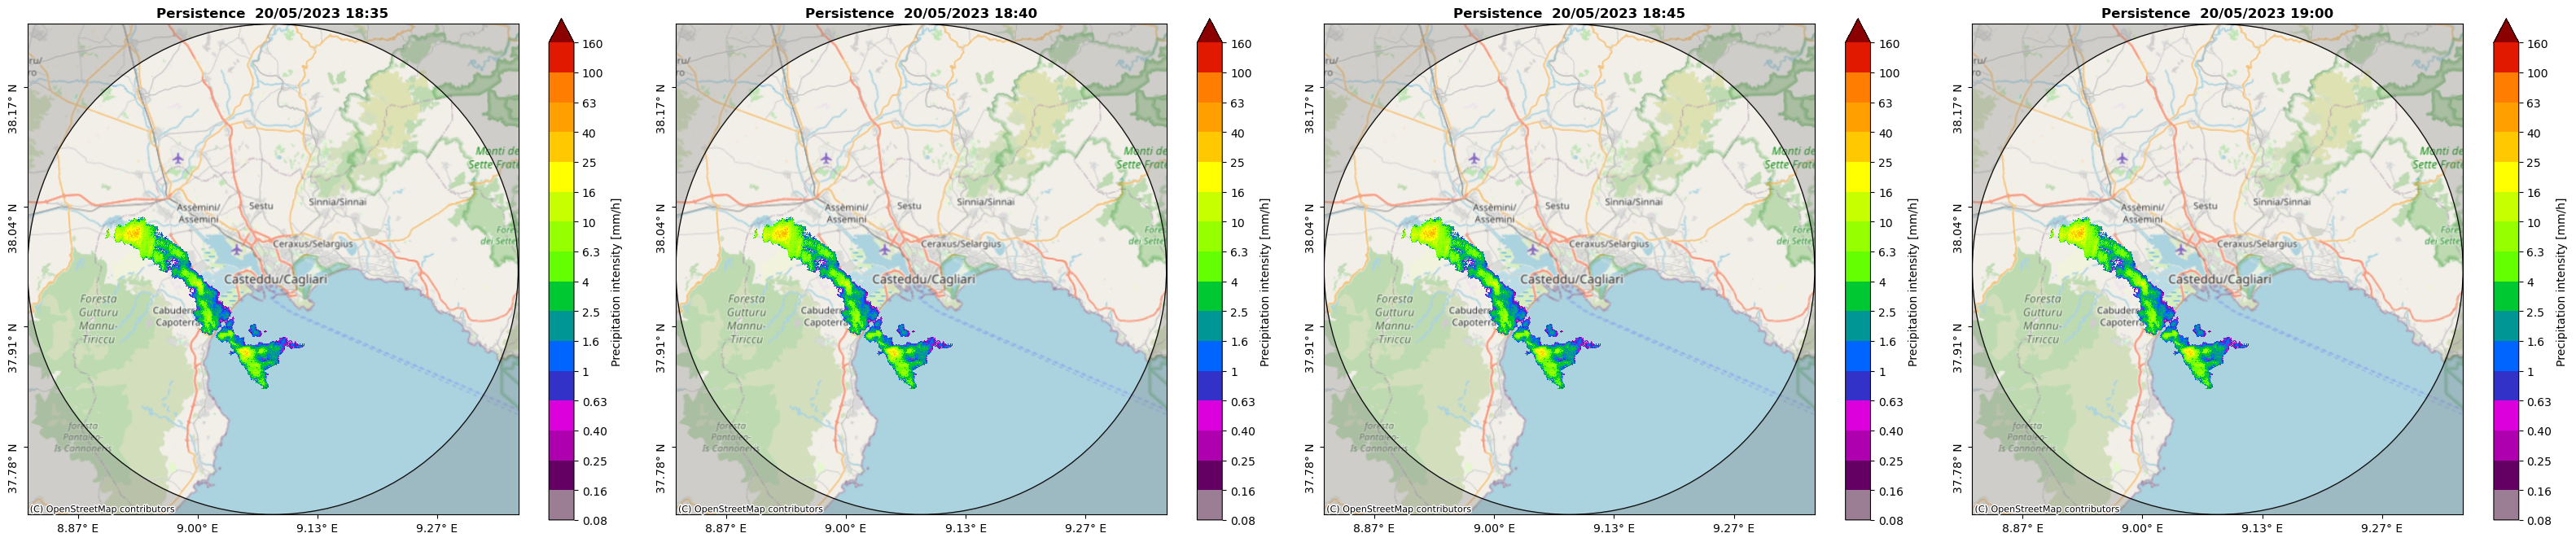

In [12]:
plot_radar_data(R_f_el, metadata_O_R, output_indices, "Persistence ")

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
 

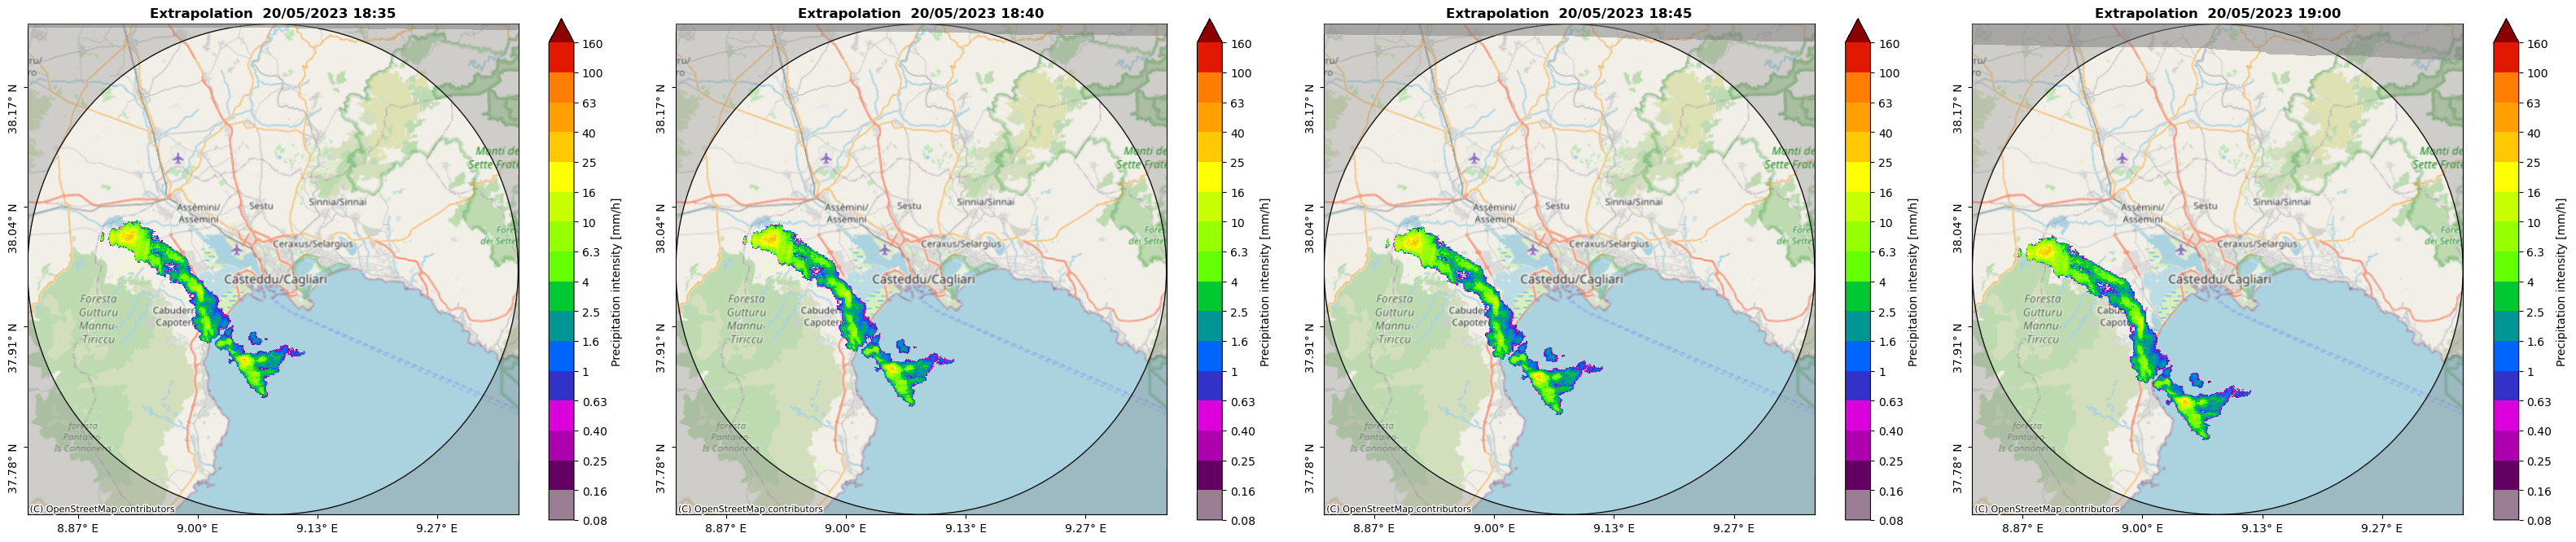

In [13]:
plot_radar_data(R_f_sl, metadata_O_R, output_indices, "Extrapolation ")

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
 

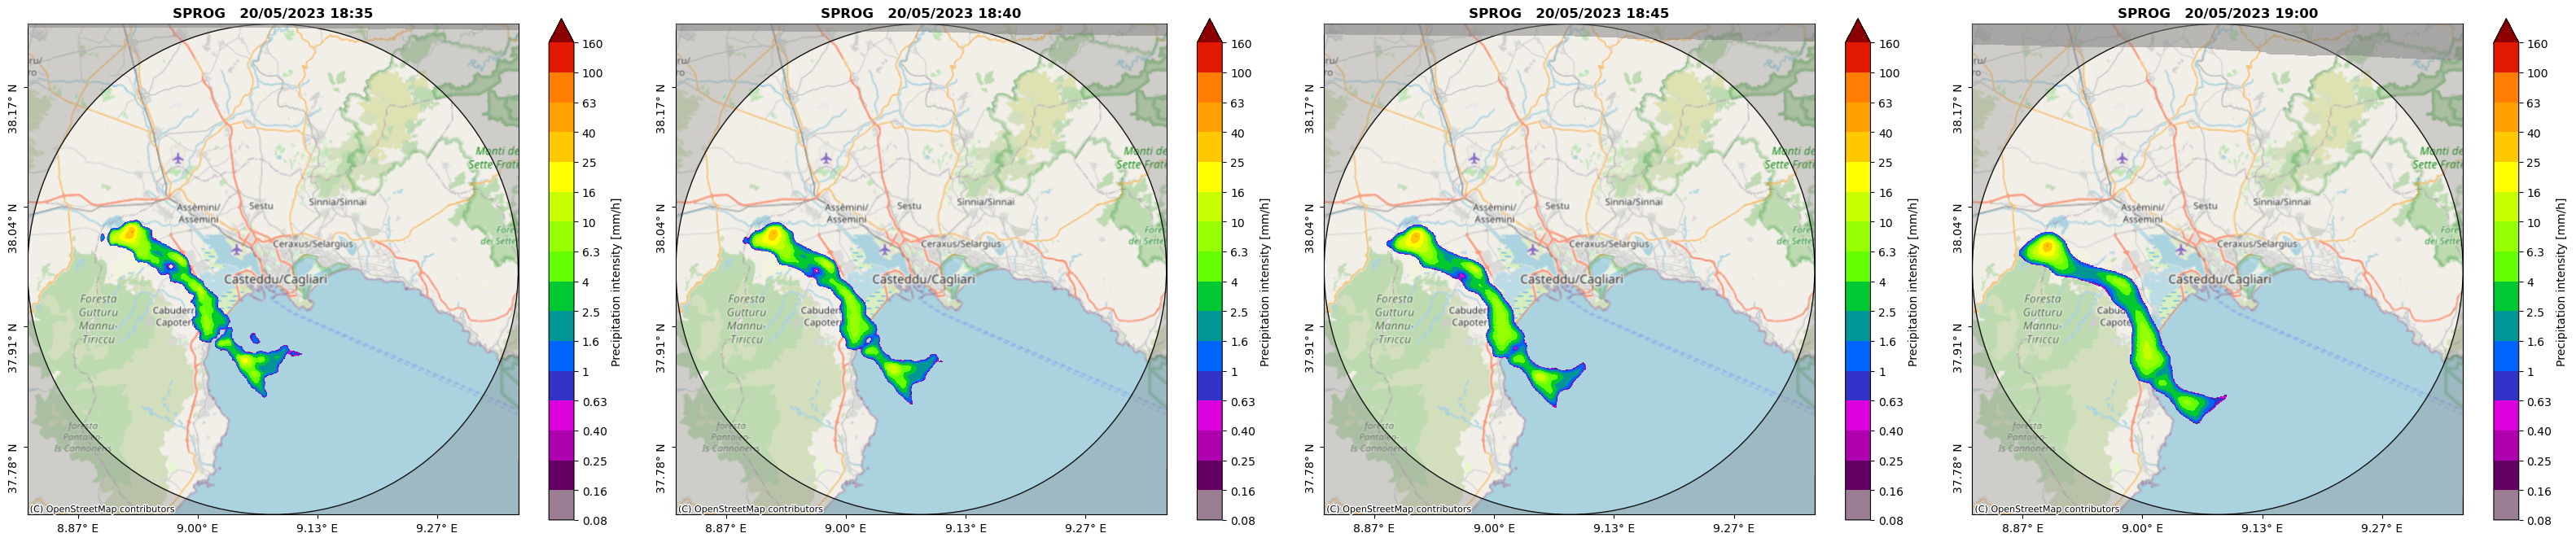

In [14]:
plot_radar_data(R_f_sp, metadata_O_R, output_indices, "SPROG  ")

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
 

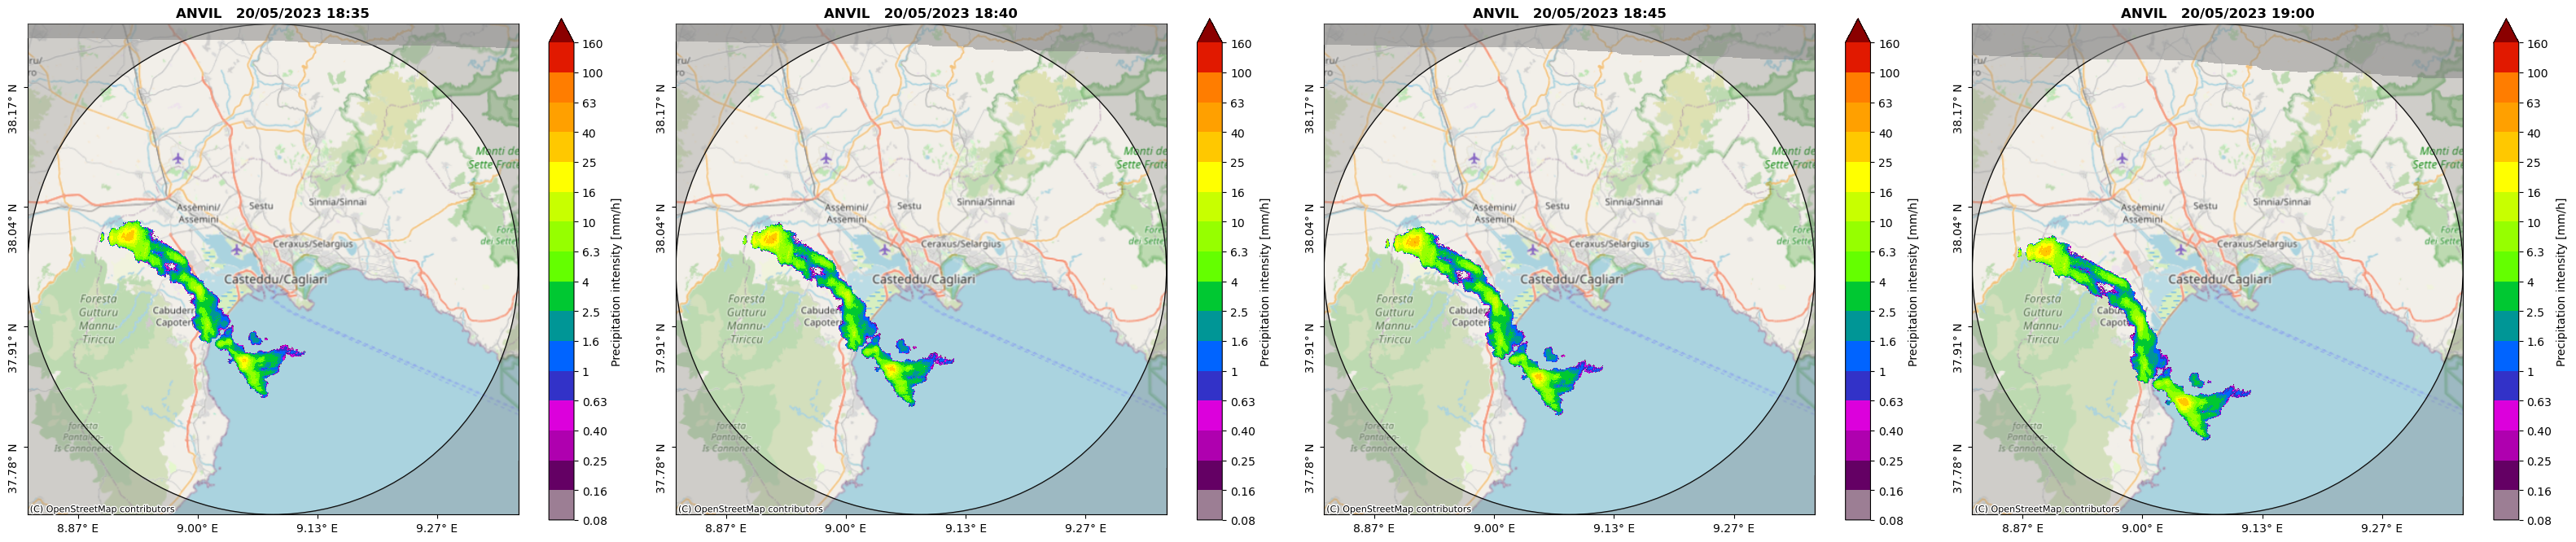

In [15]:
plot_radar_data(R_f_A, metadata_O_R, output_indices, "ANVIL  ")

# Evaluation matrices among different nowcasting methods

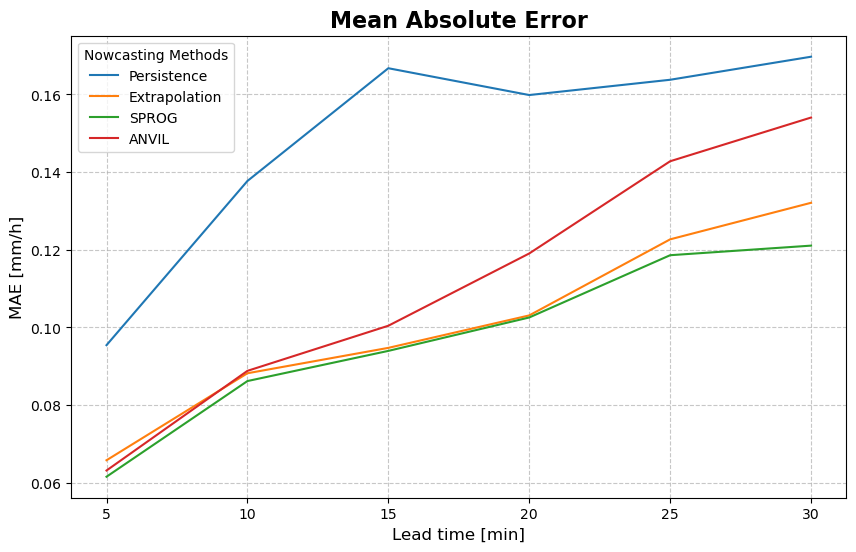

In [29]:
from pysteps import verification
# Compute MAE for all lead times,
mae = verification.get_method("MAE",type="deterministic")
mae_score_el =[]
mae_score_sl =[]
mae_score_sp =[]
mae_score_A =[]
for i in range(n_leadtimes):
    mae_score_el.append(mae(R_f_el[i, :, :], R_O_R[i, :, :])["MAE"])
    mae_score_sl.append(mae(R_f_sl[i, :, :], R_O_R[i, :, :])["MAE"])
    mae_score_sp.append(mae(R_f_sp[i, :, :], R_O_R[i, :, :])["MAE"])
    mae_score_A.append(mae(R_f_A[i, :, :], R_O_R[i, :, :])["MAE"])
x = np.arange(1, n_leadtimes + 1) * timestep


plt.figure(figsize=(10, 6))
plt.plot(x, mae_score_el, label="Persistence")
plt.plot(x, mae_score_sl, label="Extrapolation")
plt.plot(x, mae_score_sp, label="SPROG")
plt.plot(x, mae_score_A, label="ANVIL")
plt.xlabel("Lead time [min]", fontsize=12)
plt.ylabel("MAE [mm/h]", fontsize=12)
plt.title("Mean Absolute Error", fontsize=16, weight="bold")
plt.legend(title="Nowcasting Methods", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("mae_plot.png", dpi=300, bbox_inches="tight")
plt.show()

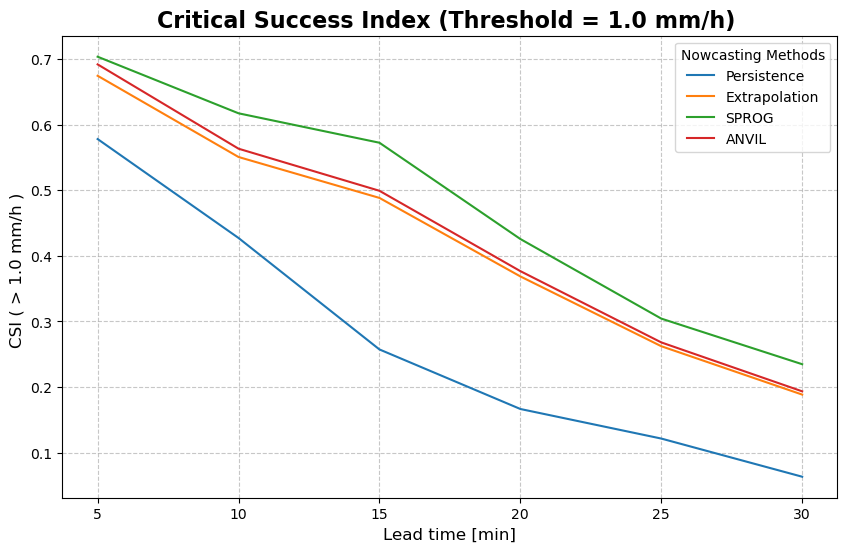

In [30]:
csi = verification.get_method("CSI",type="deterministic")
csi_score_el =[]
csi_score_sl =[]
csi_score_sp =[]
csi_score_A =[]
for i in range(n_leadtimes):
    csi_score_el.append(csi(R_f_el[i, :, :], R_O_R[i, :, :],thr=1.0)["CSI"])
    csi_score_sl.append(csi(R_f_sl[i, :, :], R_O_R[i, :, :],thr=1.0)["CSI"])
    csi_score_sp.append(csi(R_f_sp[i, :, :], R_O_R[i, :, :],thr=1.0)["CSI"])
    csi_score_A.append(csi(R_f_A[i, :, :], R_O_R[i, :, :],thr=1.0)["CSI"])
x = np.arange(1, n_leadtimes + 1) * timestep
plt.figure(figsize=(10, 6))
plt.plot(x, csi_score_el, label="Persistence")
plt.plot(x, csi_score_sl, label="Extrapolation")
plt.plot(x, csi_score_sp, label="SPROG")
plt.plot(x, csi_score_A, label="ANVIL")
plt.xlabel("Lead time [min]", fontsize=12)
plt.ylabel("CSI ( > 1.0 mm/h ) ", fontsize=12)
plt.title("Critical Success Index (Threshold = 1.0 mm/h) ", fontsize=16,weight="bold")
plt.legend(title="Nowcasting Methods", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("csi_1_plot.png", dpi=300, bbox_inches="tight")
plt.show()

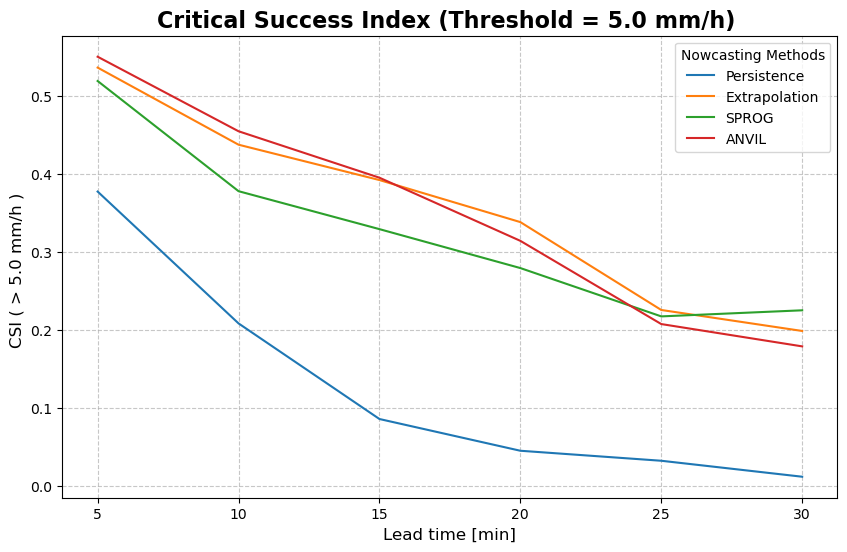

In [31]:
csi_score_el =[]
csi_score_sl =[]
csi_score_sp =[]
csi_score_A =[]
for i in range(n_leadtimes):
    csi_score_el.append(csi(R_f_el[i, :, :], R_O_R[i, :, :],thr = 5)["CSI"])
    csi_score_sl.append(csi(R_f_sl[i, :, :], R_O_R[i, :, :],thr = 5)["CSI"])
    csi_score_sp.append(csi(R_f_sp[i, :, :], R_O_R[i, :, :],thr = 5)["CSI"])
    csi_score_A.append(csi(R_f_A[i, :, :], R_O_R[i, :, :],thr = 5)["CSI"])
x = np.arange(1, n_leadtimes + 1) * timestep
plt.figure(figsize=(10, 6))
plt.plot(x, csi_score_el, label="Persistence")
plt.plot(x, csi_score_sl, label="Extrapolation")
plt.plot(x, csi_score_sp, label="SPROG")
plt.plot(x, csi_score_A, label="ANVIL")
plt.xlabel("Lead time [min]", fontsize=12)
plt.ylabel("CSI ( > 5.0 mm/h ) ", fontsize=12)
plt.title("Critical Success Index (Threshold = 5.0 mm/h) ", fontsize=16,weight="bold")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="Nowcasting Methods", fontsize=10)
plt.savefig("csi_5_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
# Compute fractions skill score (FSS) for all lead times, a set of scales and 1 mm/h
fss = verification.get_method("FSS",type="deterministic")
scales = [2, 4, 8, 16, 32, 64, 128, 256, 512]
thr = 1.0
score_el = []
score_sl = []
score_sp = []
score_A = []
for i in range(n_leadtimes):
    score_el_ = []
    score_sl_ = []
    score_sp_ = []
    score_A_ = []
    for scale in scales:
        score_el_.append(fss(R_f_el[i, :, :], R_O_R[i, :, :], thr, scale))
        score_sl_.append(fss(R_f_sl[i, :, :], R_O_R[i, :, :], thr, scale))
        score_sp_.append(fss(R_f_sp[i, :, :], R_O_R[i, :, :], thr, scale))
        score_A_.append(fss(R_f_A[i, :, :], R_O_R[i, :, :], thr, scale)) 
    score_el.append(score_el_)
    score_sl.append(score_sl_)
    score_sp.append(score_sp_)
    score_A.append(score_A_)

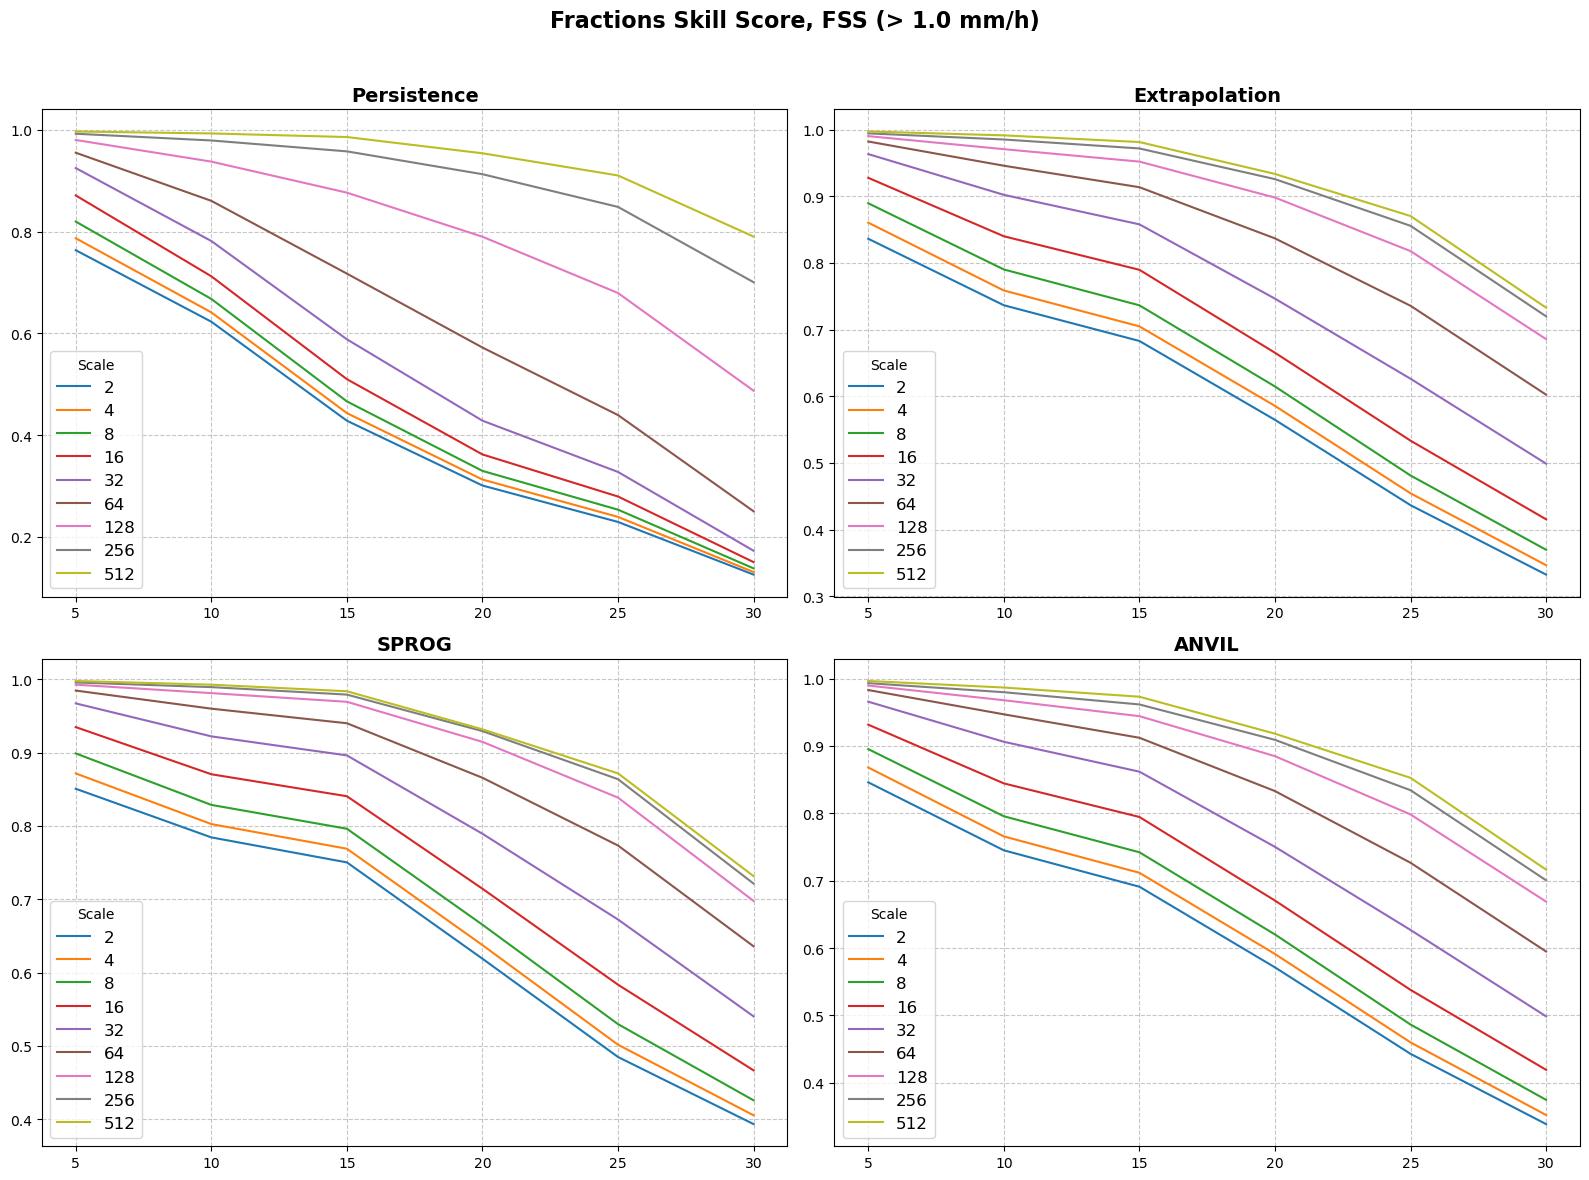

In [20]:
# plot the FSS > 1 mm/h values for all the nowcasting methods
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(16, 12))
ax1.plot(x, score_el)
ax1.set_title("Persistence", fontsize=14,weight="bold")
ax1.legend(scales, title="Scale", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)

ax2.plot(x, score_sl)
ax2.set_title("Extrapolation", fontsize=14,weight="bold")
ax2.legend(scales, title="Scale", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)

ax3.plot(x, score_sp)
ax3.set_title("SPROG", fontsize=14,weight="bold")
ax3.legend(scales, title="Scale", fontsize=12)
ax3.grid(True, linestyle="--", alpha=0.7)

ax4.plot(x, score_A)
ax4.set_title("ANVIL", fontsize=14,weight="bold")
ax4.legend(scales, title="Scale", fontsize=12)
ax4.grid(True, linestyle="--", alpha=0.7)

fig.suptitle("Fractions Skill Score, FSS (> 1.0 mm/h)", fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("fss_1__subplots.png", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
# Compute fractions skill score (FSS) for all lead times, a set of scales and 5 mm/h
fss = verification.get_method("FSS",type="deterministic")
scales = [2, 4, 8, 16, 32, 64, 128, 256, 512]
thr = 5.0
score_el = []
score_sl = []
score_sp = []
score_A = []
for i in range(n_leadtimes):
    score_el_ = []
    score_sl_ = []
    score_sp_ = []
    score_A_ = []
    for scale in scales:
        score_el_.append(fss(R_f_el[i, :, :], R_O_R[i, :, :], thr, scale))
        score_sl_.append(fss(R_f_sl[i, :, :], R_O_R[i, :, :], thr, scale))
        score_sp_.append(fss(R_f_sp[i, :, :], R_O_R[i, :, :], thr, scale))
        score_A_.append(fss(R_f_A[i, :, :], R_O_R[i, :, :], thr, scale)) 
    score_el.append(score_el_)
    score_sl.append(score_sl_)
    score_sp.append(score_sp_)
    score_A.append(score_A_)

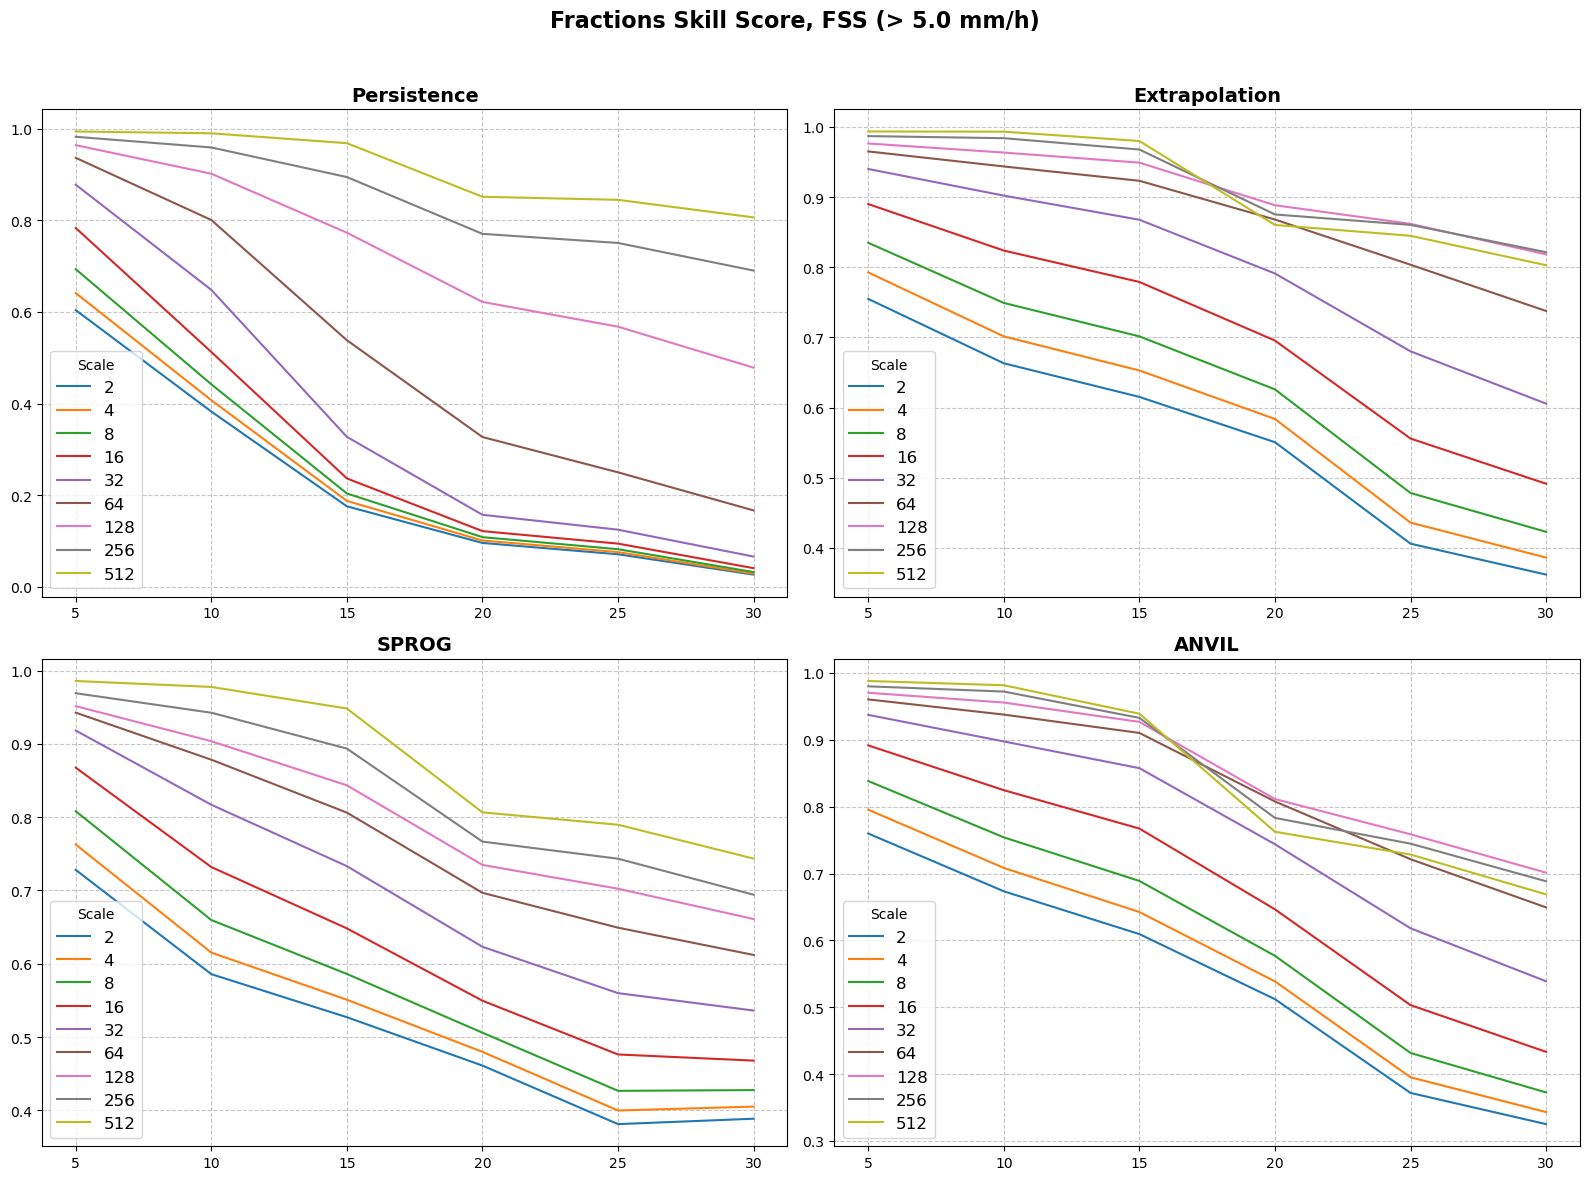

In [22]:
# plot the FSS > 5 mm/h values for all the nowcasting methods
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(16, 12))
ax1.plot(x, score_el)
ax1.set_title("Persistence", fontsize=14,weight="bold")
ax1.legend(scales, title="Scale", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)

ax2.plot(x, score_sl)
ax2.set_title("Extrapolation", fontsize=14,weight="bold")
ax2.legend(scales, title="Scale", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)

ax3.plot(x, score_sp)
ax3.set_title("SPROG", fontsize=14,weight="bold")
ax3.legend(scales, title="Scale", fontsize=12)
ax3.grid(True, linestyle="--", alpha=0.7)

ax4.plot(x, score_A)
ax4.set_title("ANVIL", fontsize=14,weight="bold")
ax4.legend(scales, title="Scale", fontsize=12)
ax4.grid(True, linestyle="--", alpha=0.7)

fig.suptitle("Fractions Skill Score, FSS (> 5.0 mm/h)", fontsize=16,weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("fss_5_subplots.png", dpi=300, bbox_inches="tight")
plt.show()

# Power Spectral Density plot comparison for 5, 10, 15 and 30 min nowcasts

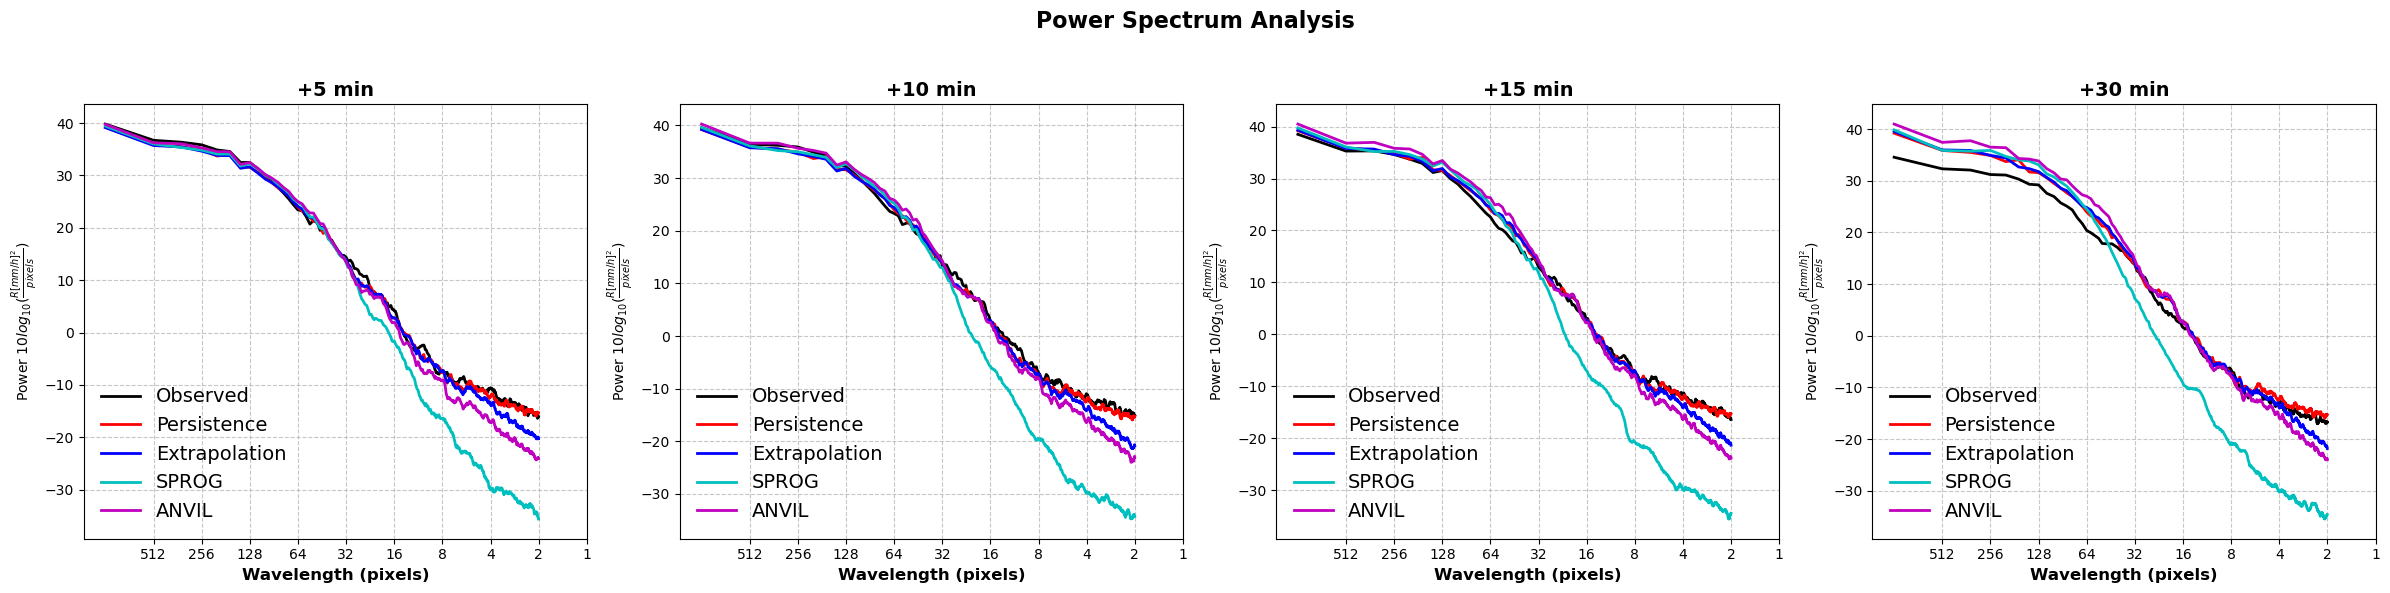

In [33]:
from pysteps.visualization import plot_spectrum1d
from pysteps.utils import rapsd

output_indices = [0, 1, 2, 5]
plot_scales = [512, 256, 128, 64, 32, 16, 8, 4, 2, 1]

# Assign the fill value to all NaNs
R_O_R[~np.isfinite(R_O_R)] = metadata_O["zerovalue"]
R_f_el[~np.isfinite(R_f_el)] = metadata_O["zerovalue"]
R_f_sl[~np.isfinite(R_f_sl)] = metadata_O["zerovalue"]
R_f_sp[~np.isfinite(R_f_sp)] = metadata_O["zerovalue"]
R_f_A[~np.isfinite(R_f_A)] = metadata_O["zerovalue"]

# Create a figure with subplots
fig, axes = plt.subplots(1, len(output_indices), figsize=(24, 6))
fig.suptitle("Power Spectrum Analysis", fontsize=16, weight="bold")

for i, idx in enumerate(output_indices):
    ax = axes[i]
    R_O_, freq_O = rapsd(R_O_R[idx, :, :], fft_method=np.fft, return_freq=True)
    R_f_el_, freq_el = rapsd(R_f_el[idx, :, :], fft_method=np.fft, return_freq=True)
    R_f_sl_, freq_sl = rapsd(R_f_sl[idx, :, :], fft_method=np.fft, return_freq=True)
    R_f_sp_, freq_sp = rapsd(R_f_sp[idx, :, :], fft_method=np.fft, return_freq=True)
    R_f_A_, freq_A = rapsd(R_f_A[idx, :, :], fft_method=np.fft, return_freq=True)

    # Plot the observed power spectrum and the model with thicker lines
    plot_spectrum1d(freq_O, R_O_, x_units="pixels", y_units="R [mm/h]", color="k", ax=ax, wavelength_ticks=plot_scales, lw=2)
    plot_spectrum1d(freq_el, R_f_el_, x_units="pixels", y_units="R [mm/h]", color="r", ax=ax, wavelength_ticks=plot_scales, lw=2)
    plot_spectrum1d(freq_sl, R_f_sl_, x_units="pixels", y_units="R [mm/h]", color="b", ax=ax, wavelength_ticks=plot_scales, lw=2)
    plot_spectrum1d(freq_sp, R_f_sp_, x_units="pixels", y_units="R [mm/h]", color="c", ax=ax, wavelength_ticks=plot_scales, lw=2)
    plot_spectrum1d(freq_A, R_f_A_, x_units="pixels", y_units="R [mm/h]", color="m", ax=ax, wavelength_ticks=plot_scales, lw=2)
    
    # Set titles, labels, and gridlines
    ax.set_title(f"+{(idx + 1) * 5} min", fontsize=14, weight="bold")
    ax.set_xlabel("Wavelength (pixels)", fontsize=12, weight="bold")
    ax.legend(["Observed", "Persistence", "Extrapolation", "SPROG", "ANVIL"], fontsize=14, loc="lower left", frameon=False)
    ax.grid(True, linestyle="--", alpha=0.7)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("power_spectrum_analysis.png", dpi=300, bbox_inches="tight")
plt.show()
